# Model evaluation: LSTM (sentiment)

---

## Table of Contents

1. [Imports](#imports)
2. [Model loading](#model-loading)
3. [Data loading and tokenization](#data-loading-and-tokenization)
4. [Evaluation](#evaluation)
5. [Report](#report)

# Imports

In [62]:
import torch
import torch.nn as nn
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import Dataset, DataLoader
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [63]:
MAX_NUM_WORDS = 20000
MAX_SEQ_LENGTH = 256

# Model loading

In [64]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super(LSTMClassifier, self).__init__()
        self.relu = nn.ReLU()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
    
    def forward(self, input_ids):
        embedded = self.embedding(input_ids)
        lstm_out, _ = self.lstm(embedded)
        pooled = torch.mean(lstm_out, dim=1)
        dropped = self.dropout(pooled)
        output = self.fc(self.relu(dropped))
        return output

In [65]:
device = 'cuda'

model = LSTMClassifier(vocab_size=MAX_NUM_WORDS, embed_dim=256, hidden_dim=256, num_classes=3)
model.load_state_dict(torch.load('./LSTM_sentiment_model/lstm_sentiment_model.pth', map_location=device))
model.to(device)
model.eval()

C:\Users\Olga\AppData\Local\Temp\ipykernel_7312\3316640829.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./LSTM_sentiment_model/lstm_

LSTMClassifier(
  (relu): ReLU()
  (embedding): Embedding(20000, 256)
  (lstm): LSTM(256, 256, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=3, bias=True)
)

# Data loading and tokenization

In [66]:
base_dir = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), '..'))

train_file = os.path.join(base_dir, 'train_sentiment.csv')
test_file = os.path.join(base_dir, 'test_sentiment.csv')

train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

In [67]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(train_data['text'])

In [68]:
class TokenizedTextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return {'input_ids': self.X[idx], 'label': self.y[idx]}

In [69]:
def encode_texts(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    return pad_sequences(sequences, maxlen=MAX_SEQ_LENGTH, padding='post', truncating='post')

In [70]:
X_test = encode_texts(test_data['text'])
y_test = test_data['label'].values

In [71]:
test_dataset = TokenizedTextDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

# Evaluation

In [72]:
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids)
        _, preds = torch.max(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Report

In [73]:
class_names = ['Negatywny', 'Neutralny', 'Pozytywny']
report = classification_report(all_labels, all_preds, output_dict=True, target_names=class_names)

In [74]:
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

   Negatywny       0.60      0.70      0.65      3391
   Neutralny       0.66      0.62      0.64      6322
   Pozytywny       0.73      0.71      0.72      5087

    accuracy                           0.67     14800
   macro avg       0.67      0.68      0.67     14800
weighted avg       0.67      0.67      0.67     14800



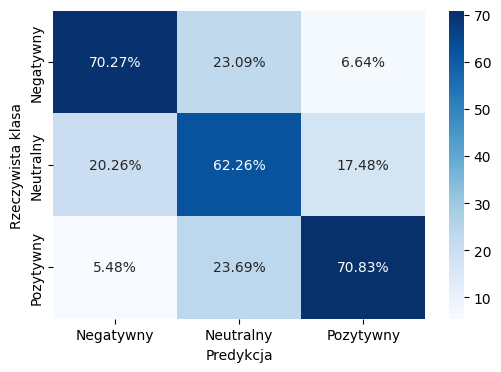

In [75]:
cm = confusion_matrix(all_labels, all_preds)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
labels = np.array([["{0:.2f}%".format(value) for value in row] for row in cm_percent])

plt.figure(figsize=(6, 4))
sns.heatmap(cm_percent, annot=labels, fmt="", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel("Predykcja")
plt.ylabel("Rzeczywista klasa")
plt.savefig("cf_mat_lstm_sentiment.png", dpi=300, bbox_inches='tight', facecolor='white')  
plt.show()

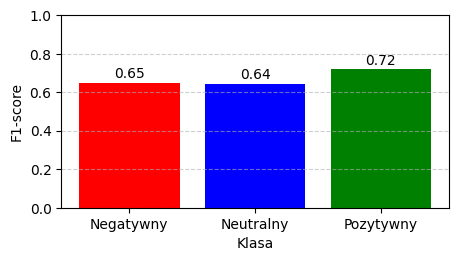

In [76]:

f1_scores = [report[label]['f1-score'] for label in class_names]

plt.figure(figsize=(5, 2.5))
bars = plt.bar(class_names, f1_scores, color=['red', 'blue', 'green'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f"{yval:.2f}", ha='center', va='bottom')

plt.ylim(0, 1.0)
plt.ylabel('F1-score')
plt.xlabel('Klasa')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.savefig("f1_bar_lstm_sentiment.png", dpi=300, bbox_inches='tight', facecolor='white')  
plt.show()